<div align="center">
    <h2>RSNA-MICCAI Brain Tumor Radiogenomic Classification</h2>
    <img src="https://user-images.githubusercontent.com/48846576/126234744-eda092a0-dcfa-4d9c-896b-aef858806298.png"  width="700" height="200">
</div>    

### What is the competition?

This is a binary image classification problem where in we will predict the genetic subtype of glioblastoma using MRI (magnetic resonance imaging) scans to detect for the presence of MGMT promoter methylation.

There are MRI scans for 585 cases given and each case has been classified as MGMT_value 0 or 1. Each case has several images in the following MRI sequence types

* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1wCE)
* T2-weighted (T2)

The MRI scan images are given in DICOM format. 

### What is DICOM?

DICOM® — [Digital Imaging and Communications in Medicine](https://www.dicomstandard.org) — is the ISO recognized international standard for medical images and related information. It defines the formats for medical images that can be exchanged with the data and quality necessary for clinical use.

> This notebook aims to do exploratory data analysis from a beginner standpoint!

In [1]:
import numpy as np
import pandas as pd
import os

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.io as pio
from plotly.subplots import make_subplots
# setting default template to plotly_white for all visualizations
pio.templates.default = "plotly_white"
%matplotlib inline
import gc


from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
res = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')
#/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv
#/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
!pip install python-gdcm


     |████████████████████████████████| 9.4 MB 831 kB/s 


In [2]:
all_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))
        
lbl_df = pd.read_csv('/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv', index_col=None)
train_files = [file for file in all_files if 'train' in file and 'train_labels.csv' not in file]

import re
train_cases = []
for file in train_files:
    train_cases.append(re.findall(r"\D(\d{5})\D", file)[0])
train_cases=list(set(train_cases))
train_cases={ int(num) : num for num in train_cases } 

In [3]:
def calculat_num_imgs(case_id, img_type='Total'):
    if img_type == 'Total':
        return len([file for file in train_files if train_cases[case_id] in file])
    else:
        return len([file for file in train_files if train_cases[case_id] in file and '/' + img_type + '/' in file])
    
for index, row in lbl_df.iterrows():
    lbl_df.at[index, 'total'] = calculat_num_imgs(row['BraTS21ID'])
    lbl_df.at[index, 'FLAIR'] = calculat_num_imgs(row['BraTS21ID'],'FLAIR')
    lbl_df.at[index, 'T1w'] = calculat_num_imgs(row['BraTS21ID'],'T1w')
    lbl_df.at[index, 'T1wCE'] = calculat_num_imgs(row['BraTS21ID'],'T1wCE')
    lbl_df.at[index, 'T2w'] = calculat_num_imgs(row['BraTS21ID'],'T2w')
    

In [4]:
lbl_df['total'] = lbl_df['total'].astype(int)
lbl_df['FLAIR'] = lbl_df['FLAIR'].astype(int)
lbl_df['T1w'] = lbl_df['T1w'].astype(int)
lbl_df['T1wCE'] = lbl_df['T1wCE'].astype(int)
lbl_df['T2w'] = lbl_df['T2w'].astype(int)
lbl_df

,BraTS21ID,MGMT_value,total,FLAIR,T1w,T1wCE,T2w
0,0,1,970,400,33,129,408
1,2,1,673,129,31,129,384
2,3,0,699,129,33,129,408
3,5,1,981,400,28,129,424
4,6,1,698,129,32,129,408
...,...,...,...,...,...,...,...
580,1005,1,92,23,23,23,23
581,1007,1,496,124,124,124,124
582,1008,1,508,60,192,192,64
583,1009,0,92,23,23,23,23


In [5]:
colors = {'0' : '#DCD427',
'1' : '#0092CC'
         }
count_df = lbl_df.groupby(['MGMT_value'])['BraTS21ID'].count().reset_index()
count_df.rename(columns={'BraTS21ID':'count'},inplace=True)
count_df['color'] = count_df['MGMT_value'].astype(str).apply(lambda x: colors[x])
count_df['MGMT_value'] = count_df['MGMT_value'].astype(str)
count_df

,MGMT_value,count,color
0,0,278,#DCD427
1,1,307,#0092CC


In [6]:
print(f"{y_}Total cases in training data  : {lbl_df.shape[0]}{res}\n{g_}Total images in training data : {lbl_df['total'].sum()}{res}")

Total cases in training data  : 585
Total images in training data : 348641


> Color Palettes 

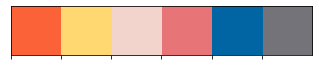

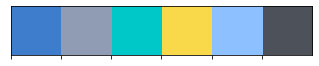

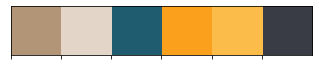

In [7]:
colors1 = ['#FC6238', '#FFD872','#F2D4CC','#E77577','#0065A2','#74737A']
colors2 = ['#3E7DCC', '#8F9CB3','#00C8C8','#F9D84A','#8CC0FF','#4D525A']
colors3 = ['#B29476', '#E3D6C9','#1F5C70','#FBA01D','#FCBC49','#393B45']
sns.palplot(sns.color_palette(colors1),size=0.9)
sns.palplot(sns.color_palette(colors2),size=0.9)
sns.palplot(sns.color_palette(colors3),size=0.9)

In [8]:
def plot_mgmt():
    pio.templates.default = "plotly_dark"
    fig = px.bar(count_df, x='MGMT_value', y='count',
           hover_data=['MGMT_value', 'count'], color='MGMT_value',
           #labels={column: label},
           color_discrete_map=colors,
           text='count')
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': count_df['MGMT_value'],
                           'title' : None, 
                           'showgrid':False},
                    yaxis={'showgrid':False,
                          'title' : 'Count'},
                    showlegend=True,
                   title = 'Cases in train data')
    fig.update_traces(textfont_size=16)
    fig.show()

plot_mgmt()

In [9]:
img_count = { 'type' : ['FLAIR','T1w','T1wCE','T2w'], 'count' : [lbl_df['FLAIR'].sum(),lbl_df['T1w'].sum(),lbl_df['T1wCE'].sum(), lbl_df['T2w'].sum()]}
img_count_df = pd.DataFrame.from_dict(img_count)
colors1 = ['#FC6238', '#FFD872','#F2D4CC','#E77577','#0065A2','#74737A']

img_type_colors = {'FLAIR' : colors1[0],
'T1w' : colors1[1],
'T1wCE' : colors1[-1],
'T2w' : colors1[-2]}

img_count_df['color'] = img_count_df['type'].apply(lambda x: img_type_colors[x])
img_count_df

,type,count,color
0,FLAIR,74248,#FC6238
1,T1w,77627,#FFD872
2,T1wCE,96766,#74737A
3,T2w,100000,#0065A2


In [10]:
def plot_image_type():
    pio.templates.default = "plotly_dark"
    fig = px.bar(img_count_df, x='type', y='count',
             hover_data=['type', 'count'], color='type',
             #labels={column: label},
             color_discrete_map=img_type_colors,
             text='count')
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':img_count_df['type'],
                             'title' : None, 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Count'},
                      showlegend=False,
                     title = 'Types of MRI Sequences in training data')
    fig.update_traces(textfont_size=16)
    fig.show()

plot_image_type()

In [11]:
fig = go.Figure()
fig.add_trace(go.Box(y=lbl_df['FLAIR'], 
                         name='FLAIR', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor=colors1[0],
                         marker_size=5,
                         line_width=1))
fig.add_trace(go.Box(y=lbl_df['T1w'], 
                         name='T1w', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor=colors1[1],
                         marker_size=5,
                         line_width=1))
fig.add_trace(go.Box(y=lbl_df['T1wCE'], 
                         name='T1wCE', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor=colors1[-1],
                         marker_size=5,
                         line_width=1))
fig.add_trace(go.Box(y=lbl_df['T2w'], 
                         name='T2w', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor=colors1[-2],
                         marker_size=5,
                         line_width=1))

fig.update_layout(xaxis={'title' : None,'showgrid' :False},
                  yaxis=dict(title='Number of images',showgrid=False,zeroline=False),
                  showlegend=False,
                 title = 'Number of images per case/MRI Sequence - Interquartile range (IQR)')    
fig.show()

## Display Sample Images
> Each case has several images in of the four different MRI scan sequences. Let's look at the sample across each category.

In [12]:
from ast import literal_eval
import matplotlib.patches as patches
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file

def display_sample(case_id = 0, mgmt_value = 1, cmap='gray', axis_off='on'):
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for img_type, ax in zip(list(img_count_df['type']), axs):
        sample_files = [file for file in train_files if train_cases[case_id] in file and img_type in file]
        dicom = read_file(sample_files[0], stop_before_pixels=False)
        ax.imshow(dicom.pixel_array, cmap=cmap)    
        ax.set_title('{}'.format(img_type),fontsize = 16)    
        ax.axis(axis_off)
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.81)
    plt.suptitle('Samples Images, Case : {}, MGMT_value = {}'.format(train_cases[case_id],mgmt_value),fontsize = 20)
    plt.show()


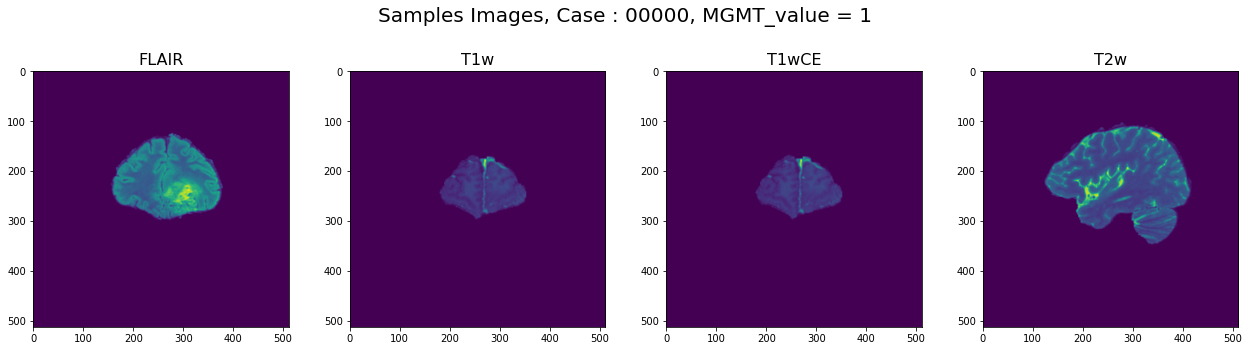

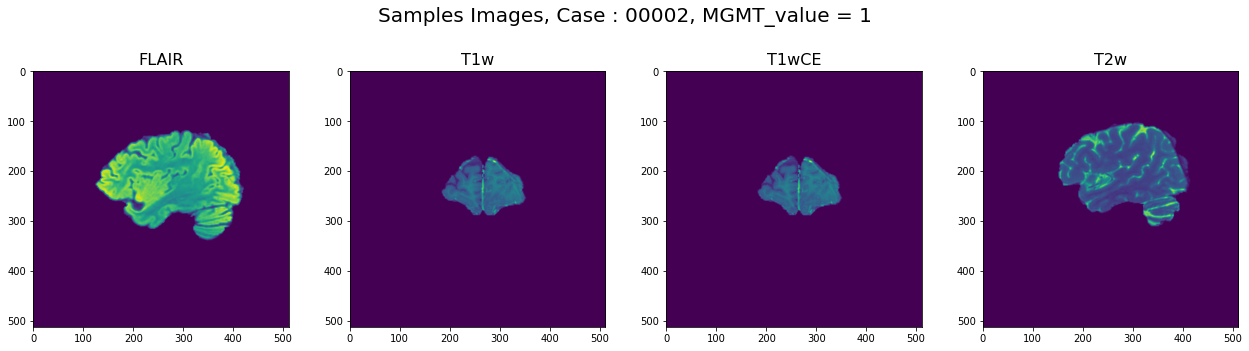

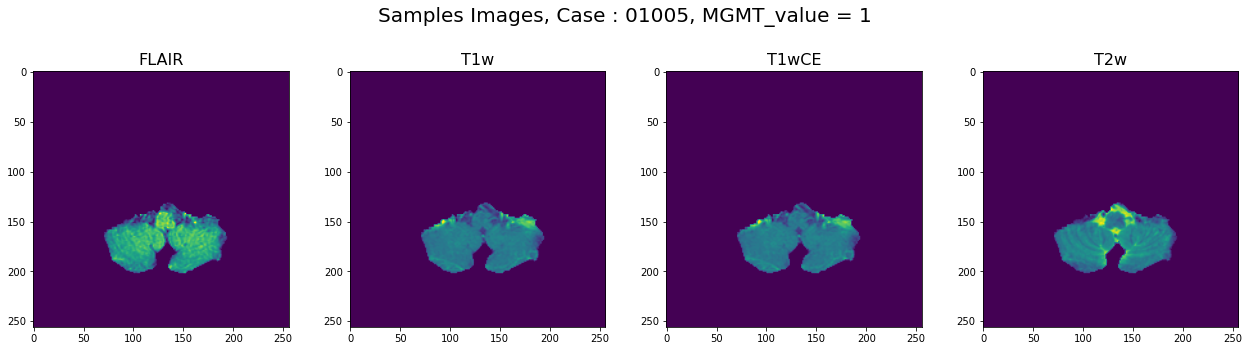

In [13]:
display_sample(case_id = 0,mgmt_value = 1, cmap='viridis')
display_sample(case_id = 2,mgmt_value = 1, cmap='viridis')
display_sample(case_id = 1005,mgmt_value = 1, cmap='viridis')

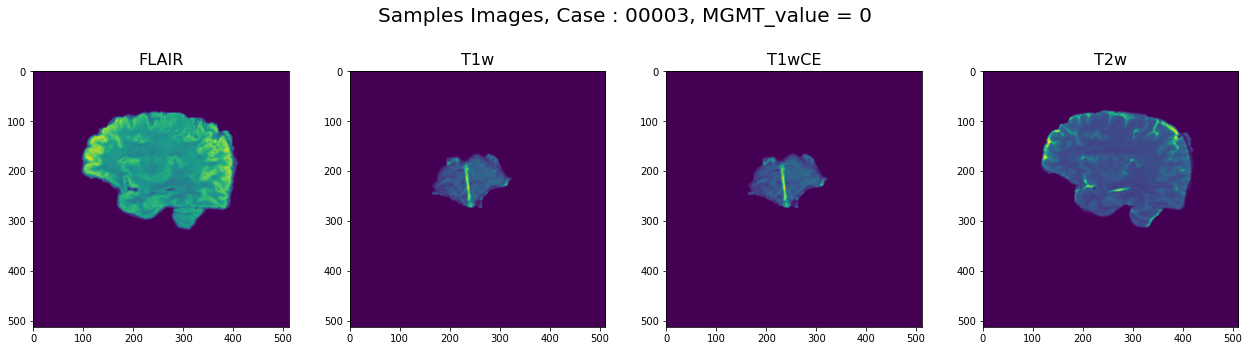

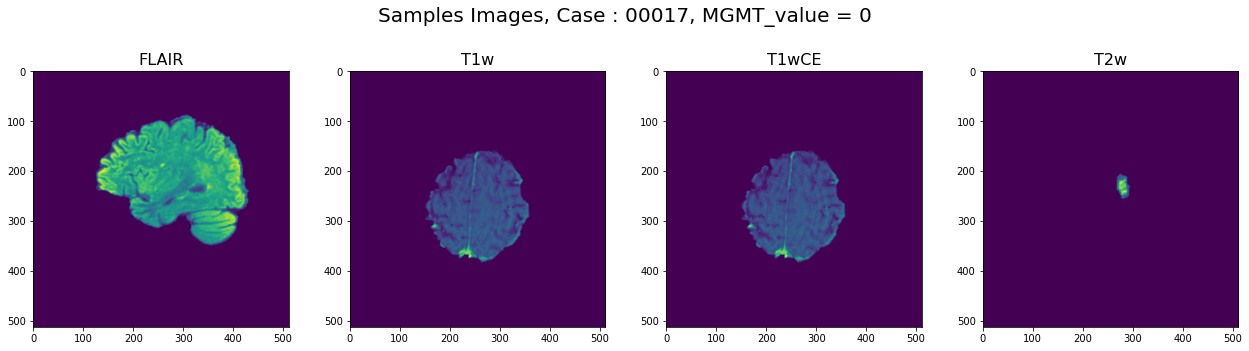

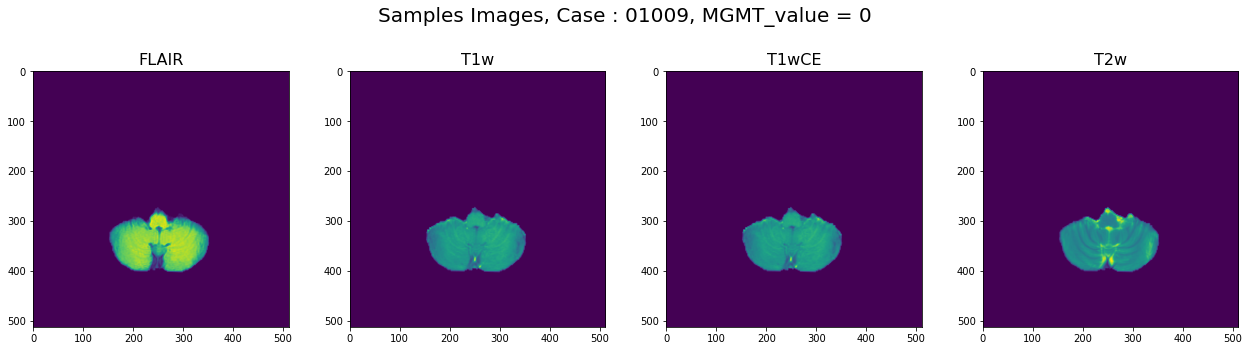

In [14]:
display_sample(case_id = 3,mgmt_value = 0, cmap='viridis')
display_sample(case_id = 17,mgmt_value = 0, cmap='viridis')
display_sample(case_id = 1009,mgmt_value = 0, cmap='viridis')

## Display all images of a case
> Let's take the case which has lesser number of images and display those

In [15]:
lbl_df.loc[lbl_df['FLAIR'] == lbl_df['FLAIR'].min()]

,BraTS21ID,MGMT_value,total,FLAIR,T1w,T1wCE,T2w
560,818,0,102,15,29,29,29


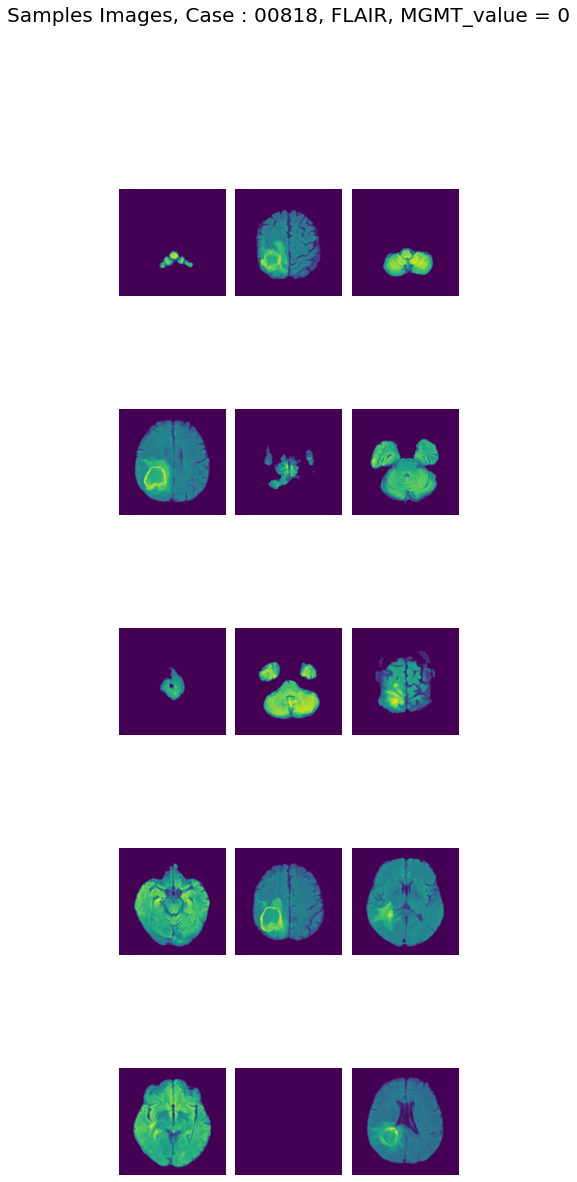

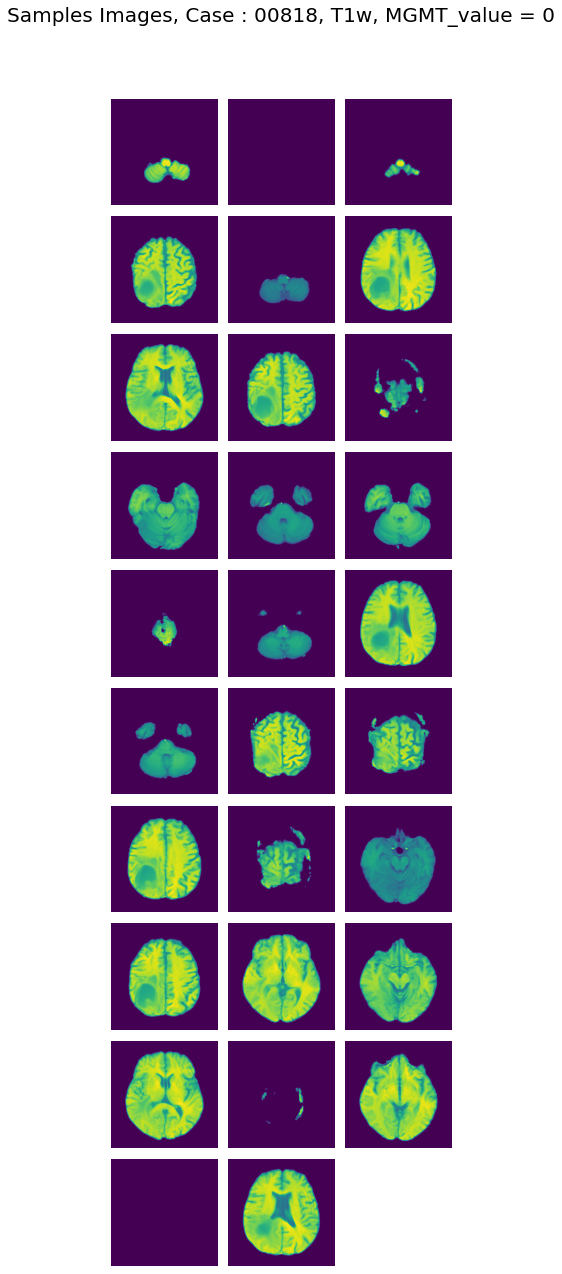

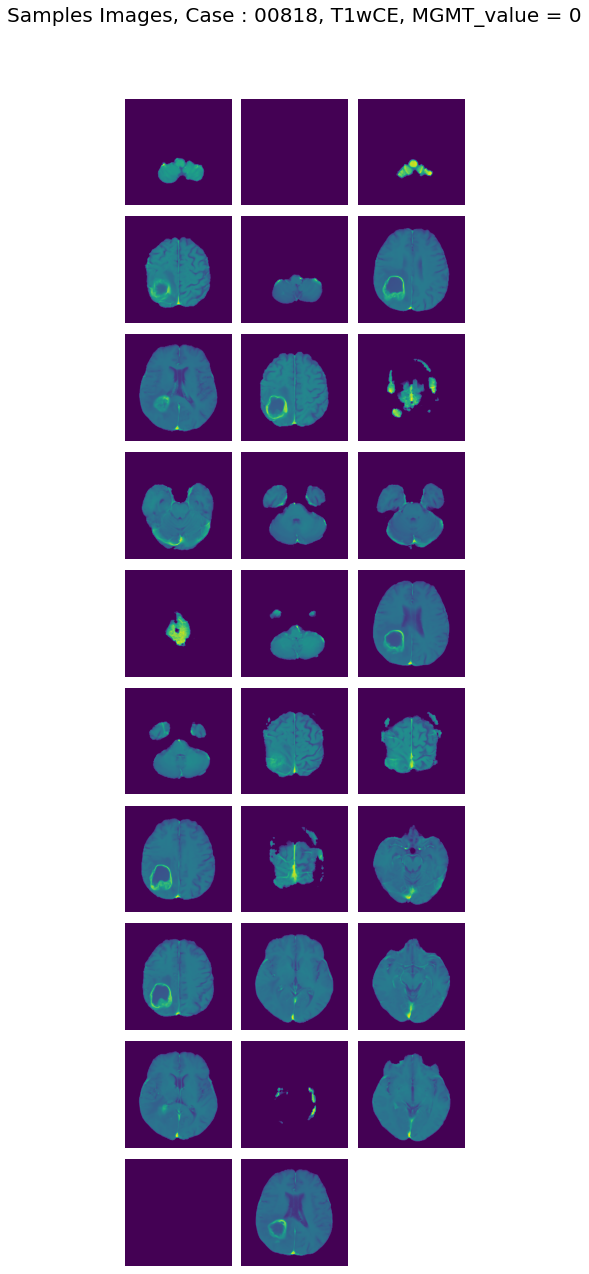

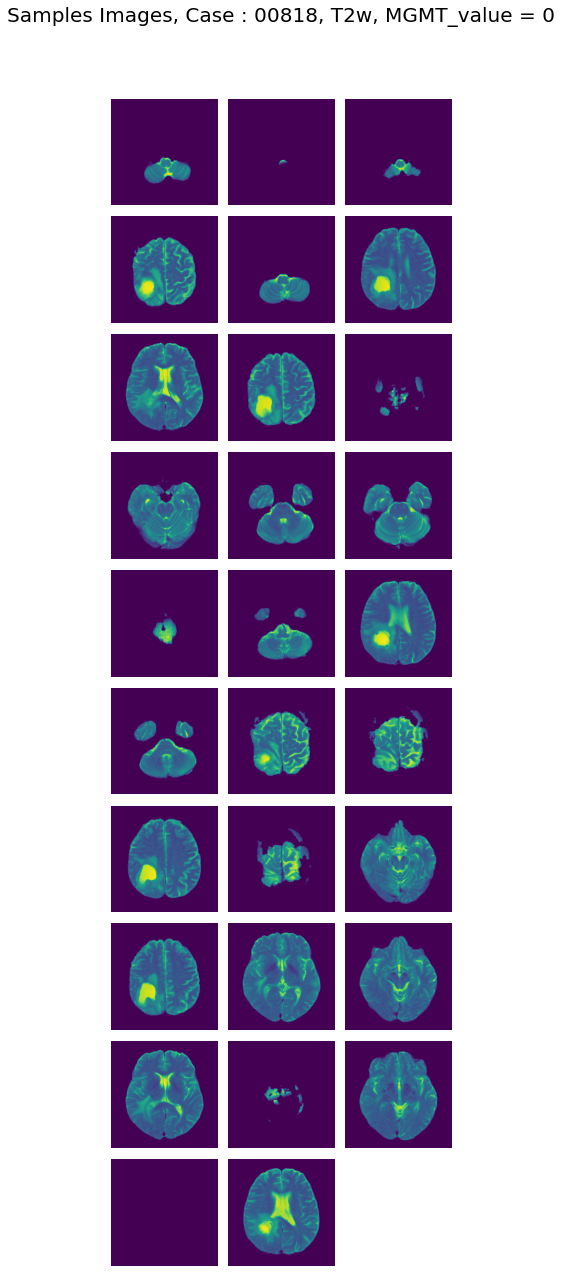

In [16]:
def display_all_images(case_id, rows = 10, cols = 3, mgmt_value = 0, mri_type='FLAIR'):
    fig1, ax1 = plt.subplots(rows, cols, figsize=(5, 18), facecolor='w', edgecolor='b')
    axs = ax1.ravel()
    sample_files = [file for file in train_files if train_cases[case_id] in file and '/' + mri_type +'/' in file]
    for file, ax in zip(sample_files, axs):
        dicom = read_file(file, stop_before_pixels=False)
        ax.imshow(dicom.pixel_array, cmap='viridis')    
        ax.axis('off')
    if mri_type != 'FLAIR':
        ax1[9,2].set_axis_off()    
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Samples Images, Case : {}, {}, MGMT_value = {}'.format(train_cases[case_id], mri_type, mgmt_value),fontsize = 20)
    plt.show()

display_all_images(818, 5, 3, 0, 'FLAIR')    
display_all_images(818, 10, 3, 0, 'T1w')    
display_all_images(818, 10, 3, 0, 'T1wCE')    
display_all_images(818, 10, 3, 0, 'T2w')    


> Work in progress!

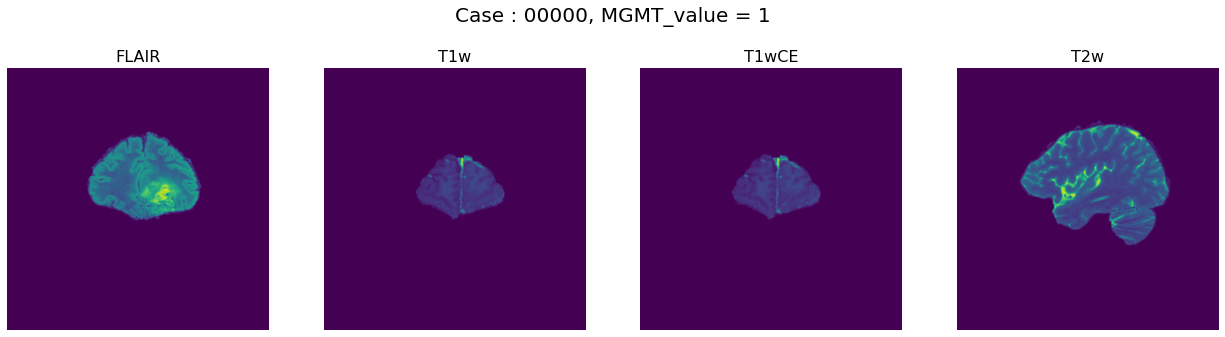

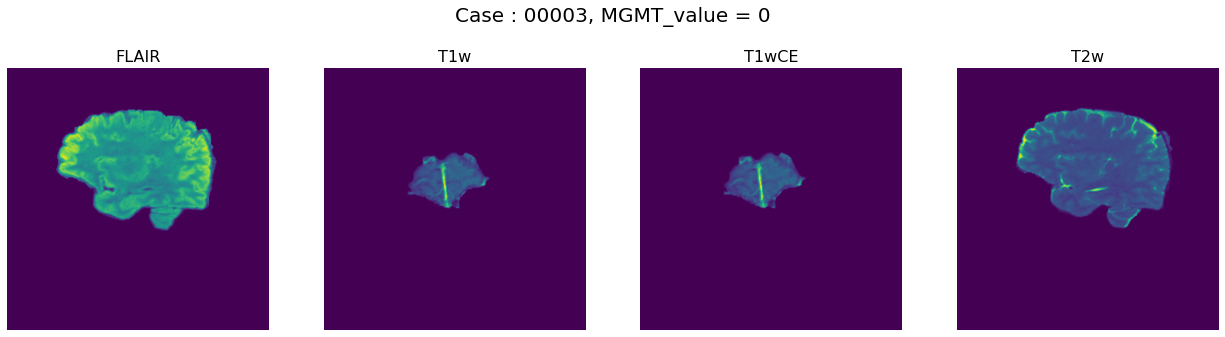

In [17]:
from ast import literal_eval
import matplotlib.patches as patches
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file

def display_sample(case_id = 0, mgmt_value = 1, cmap='gray', axis_off='on'):
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for img_type, ax in zip(list(img_count_df['type']), axs):
        sample_files = [file for file in train_files if train_cases[0] in file and img_type in file]
        dicom = read_file(sample_files[0], stop_before_pixels=False)
        ax.imshow(dicom.pixel_array, cmap=cmap)    
        ax.set_title('{}'.format(img_type),fontsize = 16)    
        ax.axis('off')
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.81)
    plt.suptitle('Case : {}, MGMT_value = {}'.format(train_cases[0],1),fontsize = 20)
    plt.show()
    
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for img_type, ax in zip(list(img_count_df['type']), axs):
        sample_files = [file for file in train_files if train_cases[3] in file and img_type in file]
        dicom = read_file(sample_files[0], stop_before_pixels=False)
        ax.imshow(dicom.pixel_array, cmap=cmap)    
        ax.set_title('{}'.format(img_type),fontsize = 16)    
        ax.axis('off')
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.81)
    plt.suptitle('Case : {}, MGMT_value = {}'.format(train_cases[3],0),fontsize = 20)
    plt.show()
    
    
display_sample(case_id = 3,mgmt_value = 0, cmap='viridis')


#display_sample(case_id = 0,mgmt_value = 1, cmap='viridis')